### Importing nessesary libraries

In [413]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity

from fuzzywuzzy import process
from sklearn.metrics import mean_squared_error


### loading and merging the dataset

In [444]:
ratings_df=pd.read_csv('ratings.csv')
movies_df=pd.read_csv('movies.csv')

merged_df = pd.merge(ratings_df,movies_df,on='movieId')

merged_df=merged_df.pivot_table(index='userId',columns='title',values='rating')
merged_df = merged_df.dropna(thresh=10,axis=1)
pivotal_df = merged_df
pivotal_df.columns.name=None

pivotal_df

,"'burbs, The (1989)",(500) Days of Summer (2009),10 Cloverfield Lane (2016),10 Things I Hate About You (1999),"10,000 BC (2008)",101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),12 Angry Men (1957),12 Years a Slave (2013),127 Hours (2010),...,Zack and Miri Make a Porno (2008),Zero Dark Thirty (2012),Zero Effect (1998),Zodiac (2007),Zombieland (2009),Zoolander (2001),Zootopia (2016),eXistenZ (1999),xXx (2002),¡Three Amigos! (1986)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.0,NaN,4.5,3.5,NaN


## performing some EDA

In [78]:
## calculate the sparcity of the utility matrix
total_entries = pivotal_df.size
zero_entries = pivotal_df.isna().sum().sum()  # Counting NaN entries as well

sparsity = (zero_entries / total_entries)

print("Sparsity of pivotal_df: {:.2%}".format(sparsity))



Sparsity of pivotal_df: 94.14%


In [129]:
## quick and detailed overview of users ratings
pivotal_df.T.describe()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
count,211.000000,26.000000,24.000000,179.000000,44.000000,226.000000,138.000000,47.000000,29.000000,105.000000,...,94.000000,125.000000,563.000000,87.000000,165.000000,632.000000,171.000000,744.00000,27.000000,764.000000
mean,4.383886,3.980769,1.479167,3.592179,3.636364,3.615044,3.278986,3.574468,3.586207,3.276190,...,4.430851,3.416000,3.479574,3.505747,3.272727,3.668513,3.783626,3.18078,3.259259,3.817408
std,0.792540,0.727747,1.658176,1.339187,0.990441,0.898168,1.326345,0.972328,1.210585,1.226669,...,0.455557,1.001483,1.200915,0.760562,0.816100,0.774293,0.991120,1.04729,0.446576,0.821387
min,1.000000,2.500000,0.500000,1.000000,1.000000,1.000000,0.500000,1.000000,1.000000,0.500000,...,3.500000,1.000000,1.000000,1.000000,1.000000,0.500000,1.000000,0.50000,3.000000,1.000000
25%,4.000000,3.500000,0.500000,3.000000,3.000000,3.000000,2.000000,3.000000,3.000000,3.000000,...,4.000000,3.000000,3.000000,3.000000,3.000000,3.500000,3.000000,2.50000,3.000000,3.500000
50%,5.000000,4.000000,0.500000,4.000000,4.000000,4.000000,3.500000,3.000000,4.000000,3.500000,...,4.500000,3.000000,4.000000,3.000000,3.000000,4.000000,4.000000,3.00000,3.000000,4.000000
75%,5.000000,4.500000,2.250000,5.000000,4.000000,4.000000,4.500000,4.000000,5.000000,4.000000,...,5.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.00000,3.500000,4.500000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.00000,4.000000,5.000000


In [130]:
## quick and detailed overview of movies ratings
pivotal_df.describe()

,"'burbs, The (1989)",(500) Days of Summer (2009),10 Cloverfield Lane (2016),10 Things I Hate About You (1999),"10,000 BC (2008)",101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),12 Angry Men (1957),12 Years a Slave (2013),127 Hours (2010),...,Zack and Miri Make a Porno (2008),Zero Dark Thirty (2012),Zero Effect (1998),Zodiac (2007),Zombieland (2009),Zoolander (2001),Zootopia (2016),eXistenZ (1999),xXx (2002),¡Three Amigos! (1986)
count,17.000000,42.000000,14.000000,54.000000,17.000000,47.000000,44.000000,57.000000,16.00000,18.000000,...,21.000000,14.000000,15.000000,38.000000,53.000000,54.000000,32.000000,22.000000,24.000000,26.000000
mean,3.176471,3.666667,3.678571,3.527778,2.705882,3.074468,3.431818,4.149123,3.62500,3.833333,...,3.523810,4.107143,3.966667,3.710526,3.877358,3.509259,3.890625,3.863636,2.770833,3.134615
std,1.236694,1.057301,0.749542,1.047984,0.936396,0.896725,0.751672,1.013150,0.67082,0.874475,...,0.872872,0.684402,0.743223,0.882499,0.876541,1.007007,0.810559,0.804479,0.966607,0.944009
min,1.000000,0.500000,2.500000,0.500000,0.500000,1.000000,1.500000,0.500000,2.00000,1.500000,...,1.500000,2.500000,2.500000,0.500000,1.000000,0.500000,2.000000,2.000000,0.500000,1.000000
25%,2.000000,3.500000,3.000000,3.000000,2.000000,3.000000,3.000000,4.000000,3.37500,4.000000,...,3.500000,4.000000,3.750000,3.000000,3.500000,3.000000,3.375000,3.500000,2.375000,2.500000
50%,3.500000,4.000000,4.000000,3.500000,3.000000,3.000000,3.500000,4.000000,4.00000,4.000000,...,3.500000,4.000000,4.000000,4.000000,4.000000,3.500000,4.000000,4.000000,3.000000,3.000000
75%,4.000000,4.375000,4.000000,4.000000,3.000000,3.500000,4.000000,5.000000,4.00000,4.375000,...,4.000000,4.500000,4.250000,4.000000,4.500000,4.000000,4.500000,4.375000,3.500000,3.875000
max,5.000000,5.000000,5.000000,5.000000,4.000000,5.000000,5.000000,5.000000,4.50000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.000000,5.000000


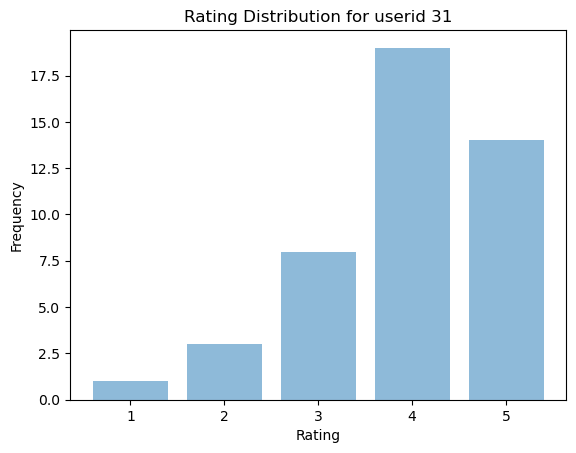

In [446]:
## counting ratings for movie 31
unique_rating=pivotal_df.loc[31].dropna().value_counts()

plt.bar(unique_rating.index,unique_rating.values, alpha=0.5)
plt.title('Rating Distribution for userid 31')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()


## building the item-item CF recommendation system

In [346]:
## creating a function to standardize matrices
def standardize(row):
    return (row - np.mean(row))/(np.std(row)+1e-12)


### using centered cosine (pearson) to find similarty

In [345]:
item_similarities=(cosine_similarity(pivotal_df.apply(standardize).fillna(0).T))
item_similarities =pd.DataFrame(item_similarities,index=pivotal_df.columns,columns=pivotal_df.columns)


### creating a function that makes prediction using weighted average

In [396]:
def get_predictions(user_id, similarity, ratings):
    """
    Generate predictions for a user based on user-based collaborative filtering.

    Parameters:
    - user_id (int): The ID of the target user.
    - similarity (pd.DataFrame): User similarity matrix.
    - ratings (pd.DataFrame): User-item ratings matrix.

    Returns:
    - prediction (pd.Series): Predicted ratings for the target user.
    """
    
    user_ratings =ratings.getrow(user_id - 1).toarray().flatten()
    user_ratings[np.isnan(user_ratings)]=0
    
    weighted_sum= np.sum(similarity * user_ratings, axis=1)
    sum_of_weighted=np.sum(abs(similarity),axis=0)+1e-15
    
    prediction =  weighted_sum/sum_of_weighted
    
    ##scaling back the predictions
    std=np.nanstd(ratings.data)
    mu=np.nanmean(ratings.data)
    prediction = prediction*std + mu
    
    return prediction


## Predicting Unrated movies of user

In [397]:
sparse_df=csr_matrix(pivotal_df)

user_id=30

user_ratings=pivotal_df.fillna(0).iloc[user_id-1]
unrated_m=user_ratings[user_ratings.values==0].index


#predicting the values
prediction=get_predictions(user_id,item_similarities,sparse_df)

#setting a dataframe with title and ratings 
predicted = pd.DataFrame({'Predicted_Ratings': pd.Series(prediction, index=pivotal_df.columns).loc[unrated_m]})
predicted = predicted.sort_values(by='Predicted_Ratings', ascending=False)

predicted


,Predicted_Ratings
Intouchables (2011),3.622320
Marley & Me (2008),3.614150
Coco (2017),3.612596
Star Wars: Episode V - The Empire Strikes Back (1980),3.611520
Fight Club (1999),3.608822
...,...
Eraserhead (1977),3.559465
Smoke (1995),3.559259
"Blind Swordsman: Zatoichi, The (Zatôichi) (2003)",3.557413
Crash (1996),3.555891


## Evaluating The model

#### !The most commenly used evaluating metric for cf recommender system is RMSE

In [433]:
def evaluate_user(user_id,pivotal_df,item_similarities):

    #storing for test
    test_actual  = pivotal_df.iloc[user_id-1].copy()
    rated =np.where(~test_actual.isna())[0]
    
    test_act = test_actual[~test_actual.isna()] 
    
    if len(test_act) < 50:
        return None
    
    #removing some values for tesitng
    rmv = np.random.choice(rated,size=50,replace=False)
    for idx in rmv:
        pivotal_df.iloc[user_id-1].values[idx]=np.nan

    prediction = get_predictions(user_id,item_similarities,sparse_df)
    
    predict_test = prediction.loc[test_act.index]

    RMSE= np.sqrt(mean_squared_error(test_act,predict_test))
    
    return RMSE



# Choose a number of users to evaluate 
num_users_to_evaluate = 200
user_ids_to_evaluate = np.random.choice(pivotal_df.shape[0], size=num_users_to_evaluate, replace=False)

# Calculate and average RMSE over multiple users
valid_rmse_values = [evaluate_user(user_id, pivotal_df, item_similarities) for user_id in user_ids_to_evaluate]
valid_rmse_values = [rmse for rmse in valid_rmse_values if rmse is not None]  # Remove None values

average_rmse = np.mean(valid_rmse_values)
print(f'Average RMSE over {len(valid_rmse_values)} users: {average_rmse}')



Average RMSE over 12 users: 1.1048349904969603


## Grouping *My* Similar Movies Together 


In [357]:
# item_similarities=pivotal_df.corr('pearson')
item_similarities=(cosine_similarity(pivotal_df.apply(standardize).T.fillna(0)))
item_similarities =pd.DataFrame(item_similarities,index=pivotal_df.columns,columns=pivotal_df.columns)

def get_similar_m(moviess):
    movies=[]
    for names,rating in moviess:
        movies.append(item_similarities.fillna(0)[names]*(rating-2.5))
    return movies

#revieling my favorite movies :)    
user_likings=[ 
              ('Godfather: Part II, The (1974)',5),
              ('Good Will Hunting (1997)',5),  
              ('Forrest Gump (1994)',5),
              ('Dark Knight, The (2008)',5),
              ('Green Mile, The (1999)',5),
              ('Avengers, The (1998)',3),
              ('Black Panther (2017)',3),
              ('Her (2013)',3),
              ('Dark Knight Rises, The (2012)',4)
]

# for name,rating in user_likings:
watched = [name for name,_ in user_likings]

similar_movies = pd.DataFrame(get_similar_m(user_likings)).sum().sort_values(ascending=False)+2.5
similar_movies = similar_movies[~similar_movies.index.isin(watched)].clip(lower=1,upper=5)
top_rated_movies =pd.DataFrame({"Similar Movies":similar_movies[similar_movies>4.5].index,"Ratings":similar_movies[similar_movies>4.5]})
top_rated_movies.reset_index(drop=True, inplace=True)

In [358]:
top_rated_movies

,Similar Movies,Ratings
0,Inception (2010),5.000000
1,Snatch (2000),4.934307
2,Saving Private Ryan (1998),4.921046
3,"Matrix, The (1999)",4.809905
4,Batman Begins (2005),4.752467
5,"Godfather, The (1972)",4.717712
6,"Beautiful Mind, A (2001)",4.675948
7,Ocean's Eleven (2001),4.604693
8,Braveheart (1995),4.581823
9,Sherlock: The Abominable Bride (2016),4.576983


    yes I would watch like movies ;)

## Trying out Content-Based recommendation system

In [17]:
## one-hot encoding genras 
genres_encoded= movies_df['genres'].str.get_dummies('|')
movies_encoded = pd.concat([movies_df['movieId'],genres_encoded],axis=1)

movies_encoded = movies_encoded.set_index('movieId')

In [176]:
#$ calculate the similarity matrix
item_similarity_cb = movies_encoded.T.corr('pearson')


In [442]:
def get_similar_ms(similars,movie_id):
    return similars[movie_id].sort_values(ascending=False)[:10]

# creating a function to find the most similar movie for the searched title
def get_movie_id(title):
    names = process.extractOne(title, movies_df['title'])
    return names[0],movies_df.loc[movies_df['title'] == names[0] , 'movieId'].values[0]


## predicting movies within similar categories with a movie

In [443]:
movie_title = 'pink panther 2'

# Get the movie ID for movie namee
target = get_id(movie_title)

# Get similar movies for the target movie ID
similar_movies_ids = get_similar_ms(item_similarity_cb, target[1]).index.tolist()

#remove the watched movie
if target[1] in similar_movies_ids:
    similar_movies_ids.remove(target[1])

# Map index (movie ID) to movie titles
similar_movies_titles = movies_df.loc[movies_df['movieId'].isin(similar_movies_ids), 'title']

# Displaying the result
print(f"Similar movies to {target[0]}:")
pd.DataFrame(similar_movies_titles)


Similar movies to Pink Panther 2, The (2009):


,title
180,Bushwhacked (1995)
3158,Joe Dirt (2001)
3358,Without a Clue (1988)
3406,Penn & Teller Get Killed (1989)
3419,"Return of the Musketeers, The (1989)"
4309,Holes (2003)
5309,Harold and Kumar Go to White Castle (2004)
7551,Scooby-Doo! Curse of the Lake Monster (2010)
8713,Mortdecai (2015)
